### Notes on 'Recipe for Disaster'

https://www.wired.com/2009/02/wp-quant/

* Li's method allow hugely complex risk to be modeled in a way previously not possible.
* Warnings about its limitations were ignored
* Things fell apart majorily in 2008.
* How did one formula have such an impact?
    * With the bond market - a multitrillion dollar system that allows big instutitions to lend to company.
    * Bond investors invest in pools of mortgage.
    * Assigning default probabilities is hard. Wall Street partially addresses this issue with tranching. It doesn't address the problems associated with correlation. What if one root cause causes everyone to default?
    * If they can't address the issue of correlation, they can't price the CDOs.
    * There was a lot of money ready to be lent.
    * In 2000, Li publish "On Default Correlation" - he didn't even look at default data. Instead he looked at prices of CDS for which default probability is a driver.
    * Now market participants felt they could accurately model correlation. They started packaging *everything*
    * CDO Market went from 275 billion in 2000 to 4.7 trillion in 2006.
    * "But in the CDO market, people used the Gaussian copula model to convince themselves they didn't have any risk at all, when in fact they just didn't have any risk 99 percent of the time. The other 1 percent of the time they blew up."
    * "Bankers securitizing mortgages knew that their models were highly sensitive to house-price appreciation. If it ever turned negative on a national scale, a lot of bonds that had been rated triple-A, or risk-free, by copula-powered computer models would blow up. But no one was willing to stop the creation of CDOs"

### Outline for the history part

* To understanding the disasterous impact, we first have to set the 
* 

## Helper code

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
def mix_of_2(mu1, sig1, mu2, sig2, perc1=.5, num=1000,seed=0):
    np.random.seed(seed)
    num1 = int(perc1*num)
    vals = np.append(np.random.normal(mu1, sig1, num1),np.random.normal(mu2, sig2, num - num1))
    return vals

def mix_of_3(mu1, sig1, mu2, sig2, mu3, sig3, percents=[.333,.333,.333], num=1000,seed=0):
    np.random.seed(seed)
    num1 = int(percents[0]*num)
    num2 = int(percents[1]*num)
    num3 = num - (num1 + num2)
    vals = np.append(np.random.normal(mu1, sig1, num1),
                     np.random.normal(mu2, sig2, num2))
    vals = np.append(vals,
                     np.random.normal(mu3, sig3, num3))
    return vals

# What is your favorite example of 'illegal math'?

I'm going to shamelessly re-interpret the question. Instead of seeing this as 'illegal according to the rules of math', I'll go with 'should have been actually illegal'.

With that, I present to you a beautiful and useful chunk of math: **the copula**, a mathematical device that deluded the financial industry into modeling the unknowable. Its misuse spurred trillions of dollars in additional Collateralized Debt Obligations ('CDO's), providing fuel for the worst financial collapse since the Great Depression.

This answer will come in two parts. First, I'll explain the copula in all it's mathematical beauty and practical utility. Following that, I'll speak to its historical abuse and how it, quite dramatically, contributed to the 2008 Financial Crisis.

## What problem does the Copula solve?

Let's say you come across this probability density:

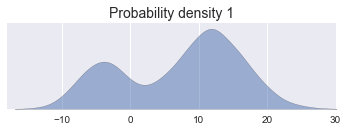

In [13]:
from scipy.stats import gaussian_kde

list1 = mix_of_2(-4, 3.5, 12, 5, perc1=.3, num=10000)

def list_density(lst,title,ax,vertical=False):
    
    lst = sorted(lst)
    density = gaussian_kde(lst)
    x = np.linspace(min(lst)-2,max(lst)+2,300)
    
    if vertical:
        ax.fill_betweenx(x, 0, density(x),alpha=.5)
    else:
        ax.fill_between(x, 0, density(x),alpha=.5)
    if title:
        ax.set_title(title,fontsize=14)
    ax.set_yticks([])
    return ax

fig, ax = plt.subplots(figsize=(5,2))

ax = list_density(list1,'Probability density 1',ax)
ax.set_xlim((-18,30))
fig.tight_layout()
fig.savefig('prob1.png',dpi=150)

And another one:

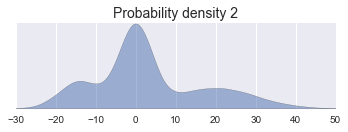

In [37]:
list2 = mix_of_3(-14, 5, 0, 4, 20, 10, percents=[.2,.5,.3], num=100000)

fig, ax = plt.subplots(figsize=(5,2))
ax = list_density(list2,'Probability density 2',ax)
ax.set_xlim((-30,50))
fig.tight_layout()
fig.savefig('prob2.png',dpi=150)
prob2ticks = ax.xaxis.get_majorticklocs()
pass

Easy so far, but here it gets a bit harder. I give you this task:

I now tell you the correlation between these random variables is .3. Generate samples from a *joint* distribution with that correlation while maintaining the marginal distributions we see above.

How would you do this? More generally, how do you build a joint distribution from a set of arbitrary marginal distribution with a particular joint structure enforced?

With the black magic that is the copula.

## What is the Copula?

In essense, the copula refers to the 'joint-y' piece of a joint distribution. 

To understand that garbage sentence, we have to understand two other closely related topics:

1. the probability integral transform (link): Imagine we have a continuous random variable $X$ and it's cumulative density function (link) ('CDF') $M(c)=\textrm{Prob}(X<c)$. This tells us that if we sample values of our random variable ($x_1,x_2,\cdots,x_n$) and plug thus into the CDF, the output ($M(x_1),M(x_2),\cdots,M(x_n)$) will be uniformly distributed between 0 and 1. Easy enough!

2. inverse transform sampling (link): If we want to generate samples of $X$, then we can generate uniform random numbers ($u_1, u_2, \cdots, u_n$) and plug them into the *inverse* CDF. In other words, $M^{-1}(u_1),M^{-1}(u_2),\cdots,M^{-1}(u_n)$ will have the distribution of $X$.

See how these are closely related? The CDF of $X$ transforms between the uniform distribution and the distribution of $X$. Ok, hold onto these thoughts!

Now, imagine you have $D$ random variables $X_1,X_2,\cdots, X_D$ with some joint probability density $p(X_1,X_2,\cdots, X_D)$. From this joint distribution, you can always calculate the marginal CDF of each random variables (call them $M_i(\cdot)$). Now here's the magic idea. Sample a vector $x_1,x_2,\cdots, x_D$ from the *joint* distribution and plug each into their respective CDF, yielding a new vector: $M_1(x_1),M_2(x_2),\cdots, M_D(x_D)$. Now do that $N$ times, yielding an $N$-by-$D$ matrix of numbers. Due to the probability integral transform, we know each column (associated with a particular $X_i$) will have a uniform distribution. But each row was generated by a sample from the *joint* distribution, so baked into these uniform-looking numbers is that joint distribution. The distribution governing this matrix is called the copula. Is it starting to feel like just the joint-y piece yet?

But here's the cool part. Imagine we show up with an entirely *new* set of marginal distributions, represented with their CDFs: $W_1(\cdot),W_2(\cdot),\cdots,W_D(\cdot)$. We want to generate samples with these marginals, but with the joint structure extracted in our $N$-by-$D$ matrix. Well, using the idea of inverse transform sampling, we just plug the values of our matrix into their respective $W_i$. The result is a set of samples that have our new marginal distribution but have the joint behavior of $p(X_1,X_2,\cdots, X_D)$. 

Excuse me, but how fucking wild is that? The math gods have given us a golden surgical device that allows us to separate marginal and joint behavior. We can separate them and mix/match anyway we want!

## Back to the problem

So we want to generate samples with the two marginals we saw earlier, but we want to enforce that 0.8 correlation. Armed with our copula idea, let's take the joint-y correlation part of a multivariate Guassian and combine it with these marginal. That is, let's:

(maybe exclude these steps?)

1. Generate N size-2 samples from a multivariate Gaussian with a correlation of 0.8, yielding an N-by-2 matrix.
2. Transform each column by plugging it into their respective marginal CDF. Each column will now look uniformly distributed.
3. Plug them into the inverse cdf of the marginal distributions we see in our graphs, yielding new samples.

So did it work? Let's see

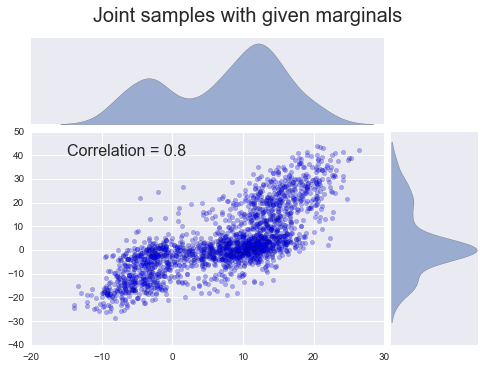

In [58]:
from scipy.stats import norm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def gen_gaussian_copula(corr,num=1000):
    norm_samples = np.random.multivariate_normal(np.array([0,0]),
                                                 np.array([[1,corr],[corr,1]]),num)
    
    for i in range(2): 
        norm_samples[:,i] = norm.cdf(norm_samples[:,i])
    
    return norm_samples

corr = 0.8
copula = gen_gaussian_copula(corr,2000)

#The inverse CDF of the marginal is just the percentile function:

samples = copula.copy()
samples[:,0] = np.percentile(list1,copula[:,0]*100)
samples[:,1] = np.percentile(list2,copula[:,1]*100)

fig, ax = plt.subplots()
ax.scatter(samples[:,0],samples[:,1],alpha=.3)

divider = make_axes_locatable(ax)
ax_marginal_x = divider.append_axes("top", size=1.2, pad=0.1)
ax_marginal_y = divider.append_axes("right", size=1.2, pad=0.1)
ax_marginal_x = list_density(samples[:,0],None,ax_marginal_x)
ax_marginal_x.set_xticks([])
ax_marginal_y = list_density(samples[:,1],None,ax_marginal_y,vertical=True)
ax.xaxis.set_visible(True)
ax_marginal_y.set_xticks([])
ax.annotate('Correlation = 0.8',xy=(-15,40),fontsize=16)

fig.suptitle('Joint samples with given marginals', fontsize=20)
fig.savefig('joint.png',dpi=150)

pass

Problem solved! Our joint samples have a correlation of 0.8 and have the marginals we arrived with.

Pretty cool right? But how could this cute math lesson wreak havoc over the US financial system?

### Modeling Mortgage Backed Securities

In the late 1990s, bond investors were desperate to lend money at attractive rates. They had seen nearly two decades of declining yields and would be quick to consider alternative financial products which could escape the trend.

A popular product was the Mortgage Backed Security (link) (MBS), a security that had some priority claim to the cash flows produced by a group of mortgage payers. So if an investment bank owned some large set of mortgages, they could sell securities that promised the cash flows of these mortgages. But some securities were prioritized over others. So in a given month, when looking at a large lump sum payment from these payers (where some people defaulted on their payment), the investment bank would first pay the owners of the highest priority security. With what's left over, they pay the owners of the next priority security (and so on). To compensate for the increased probability of a non-payment, lower claims (referred to as lower 'tranche's) were cheaper and hence offered more yield. Bond investors were happy to see this.

But there was a major mathematical impediment stifling the issuances of these securities: *default correlation*.

The popularity of these products depends heavily on the confidence with which market participants can price them. In the case where all mortgage payers default independently, pricing is easy. First, a modeler estimates the default distribution for payers *seperately* (which is do-able) and simulates their cash outflows over time. Then they pass these through the prioritization structure, yielding a distribution of cash flows for each tranch. With a particular risk appetite, an investor can decide exactly what price each tranch is worth.

But what if mortgage defaults are correlated? As an extreme example, imagine they are perfectly correlated. That means each month either every payer pays their fully owed amount or no one pays. In this absurd example, tranching accomplishes nothing and each security should be priced the same. So correlation matters *a lot*.

So how on earth would you model default correlation between two payers[1]? The typical (and arguably sane) approach would be to look at data where one payer defaulted and use the probability that the other payer also defaulted. But defaulting is a rare event, so 'data where one payer defaulted' is a small set. This problem is exacerbated by another order of magnitude when you consider three payers. With only a recent history of relevant data and many more payers, this quickly becomes impossible.

So now what?

### David Li introduces the Gaussian copula

In 2000, David Li published "On Default Correlation: A Copula Function Approach" - a superficially genuis solution to this intractable problem. His recommendation comes in two parts:

1. To determine default correlations, use the prices of well traded credit securities that are partially driven by market expectations of default probabilities. To illustrate, say we want to determine the default correlation between two payers. Let's also say these payers pay fluctuating insurance premiums to protect them from default. Li suggests we use the correlation in these premiums to determine their default correlation. If this feels dubous, that's because it is. 

2. Armed with a default correlation number, use a Gaussian copula to turn payers' separate distributions of default into a *joint* distribution of default for *all* payers.

With this, we can take this joint distribution to determine cash flows and proceed as we did in the independent case, yielding prices. Not only that, this treatment is by no means specific to the securitization of mortgage payments. It can be done with *any* set of debt obligations we fear are correlated. So not only did this open up the flood gates for mortgage securitization, but also for further securitizations of these securities. This second generation of securitizations were the infamous CDOs. This was a primary driver of CDO market's grwoth from 275 billion in 2000 to 4.6 trillion by 2006.

From here, I'm sure the story is at least partially familiar to you. Risk was repeatedly misunderstood, misrepresented and sold off to investor blind to the cash flow drivers, resulting in a historic financial crisis. Since that story has been well hashed out, let's bring the attention back to the copula. 

### Why did the copula hurt so much?

The problem at hand is an irreducible difficulty of financial modeling. That is, modeling correlations of many, many interrelated things. Doing so is particularly difficult when our interest lie in rare events. To have these correlations would be to know the distribution of all possibilities conditional on any event. It's a ridiculous, almost crystal ball level expectation. It's impossible simply because our history has been a minuscule subset of all possible histories. There exists no mathematical trick that will solve this problem. This is the main reason the copula didn't work, but it's not the reason for it's disasturous impact.

That would be the illusion it created. With the introduction of the copula, market participants traded as though they had these correlations figured out. In effect, they were zero-ing out the chances of unlikely but severe events. Repackaging and reselling to the less familiar only magnified this illusion.

This is not to say such securities can't be priced and/or traded. It is to say that doing so should have been done with the explicit acknowledgement that there are true unknowables in this problem. The effect would have been conversative prices and lower volumer. A law that prevented the copula from acting as this magic wand would have lessened the pain of 2008. In other words, it should have been illegal.





### Footnotes

[1] It's actually not two individual payers, but rather groups of payers that are sufficiently similar (similar FICOs, mortgage rate, whatever else...) that we consider them as one payer.

### Sources

[1] I first learned about the copula and it's abs